# Market Segmentation Python Code

# Exploring Data

### Importing all the imported and required packages

In [61]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import entropy
from patsy import dmatrices
from scipy.stats import chi2_contingency
import matplotlib.patches as mpatches
from statsmodels.graphics.mosaicplot import mosaic
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from adjustText import adjust_text

### Loading the dataset

In [62]:
mcdonalds_data = pd.read_csv('/Users/kanishka.arora/Downloads/mcdonalds.csv')

### Principal Component Analysis

/var/folders/_v/c9k8zfr522j0s0hfdvvgv0s80000gn/T/ipykernel_46029/1621847168.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  MD_x = mcdonalds_data.iloc[:, :11].applymap(lambda x: 1 if x == 'Yes' else 0)


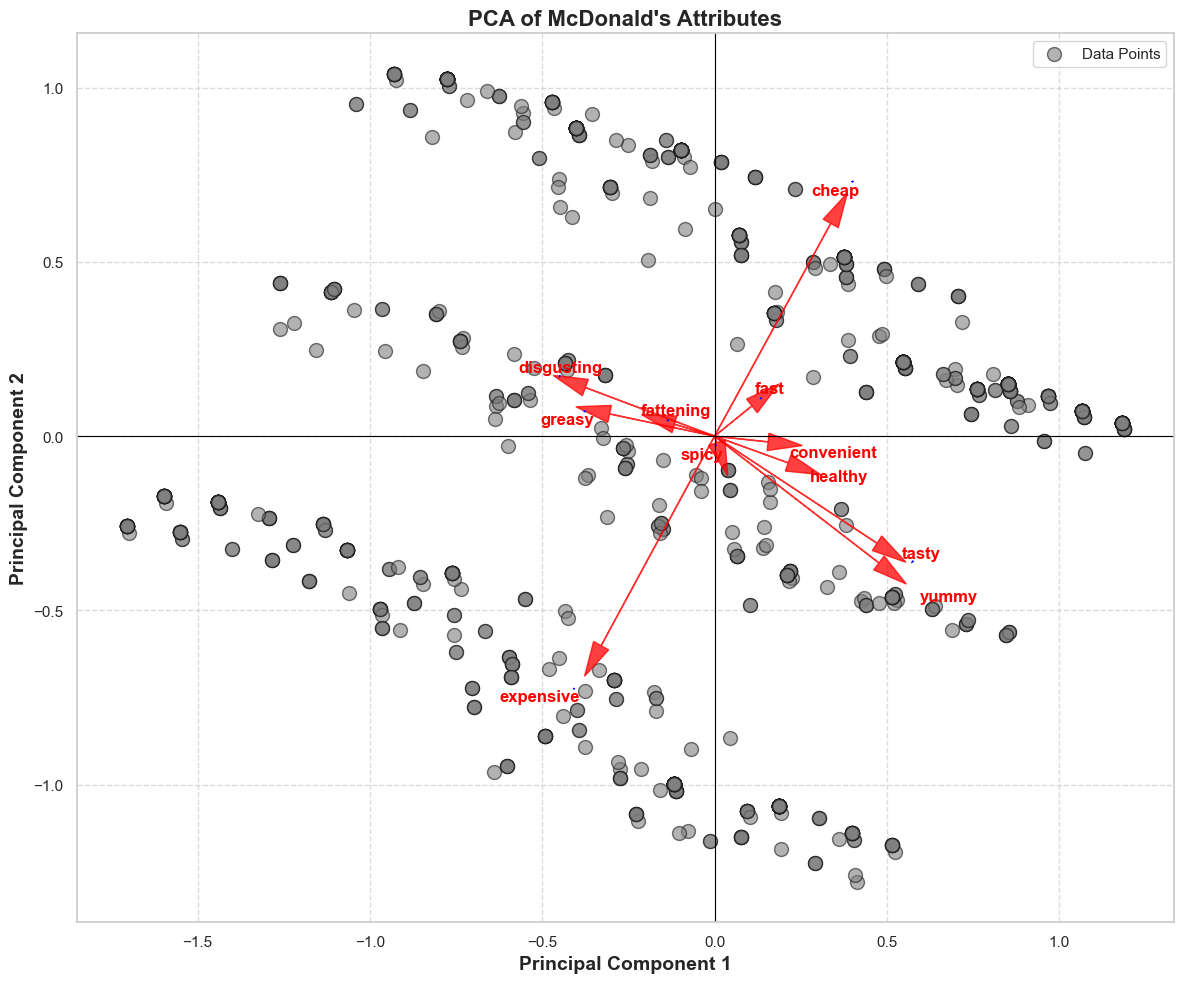

In [63]:
# Convert YES/NO to binary
MD_x = mcdonalds_data.iloc[:, :11].applymap(lambda x: 1 if x == 'Yes' else 0)

# Principal Components Analysis (PCA)
MD_pca = PCA()
MD_pca_fit = MD_pca.fit(MD_x)

# Transform data to principal components
MD_pca_proj = MD_pca.transform(MD_x)

# Plot PCA results with annotations
plt.figure(figsize=(12, 10))
plt.scatter(MD_pca_proj[:, 0], MD_pca_proj[:, 1], color='grey', alpha=0.6, s=100, edgecolor='k', label='Data Points')

# Collect all texts to adjust their positions
texts = []
for i, (pc1, pc2) in enumerate(zip(MD_pca.components_[0, :], MD_pca.components_[1, :])):
    plt.arrow(0, 0, pc1, pc2, color='red', alpha=0.75, head_width=0.05, head_length=0.1)
    text = plt.text(pc1 * 1.2, pc2 * 1.2, MD_x.columns[i], color='red', ha='center', va='center', fontsize=12, fontweight='bold')
    texts.append(text)

# Adjust text positions to avoid overlap
adjust_text(texts, arrowprops=dict(arrowstyle='->', color='blue'))

# Customize plot appearance
plt.xlabel('Principal Component 1', fontsize=14, fontweight='bold')
plt.ylabel('Principal Component 2', fontsize=14, fontweight='bold')
plt.title('PCA of McDonald\'s Attributes', fontsize=16, fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.7)
plt.axhline(0, color='black', linewidth=0.8)
plt.axvline(0, color='black', linewidth=0.8)
plt.legend(loc='upper right')
plt.tight_layout()

plt.show()

# Extracting Segments

### 1. Using K-Means

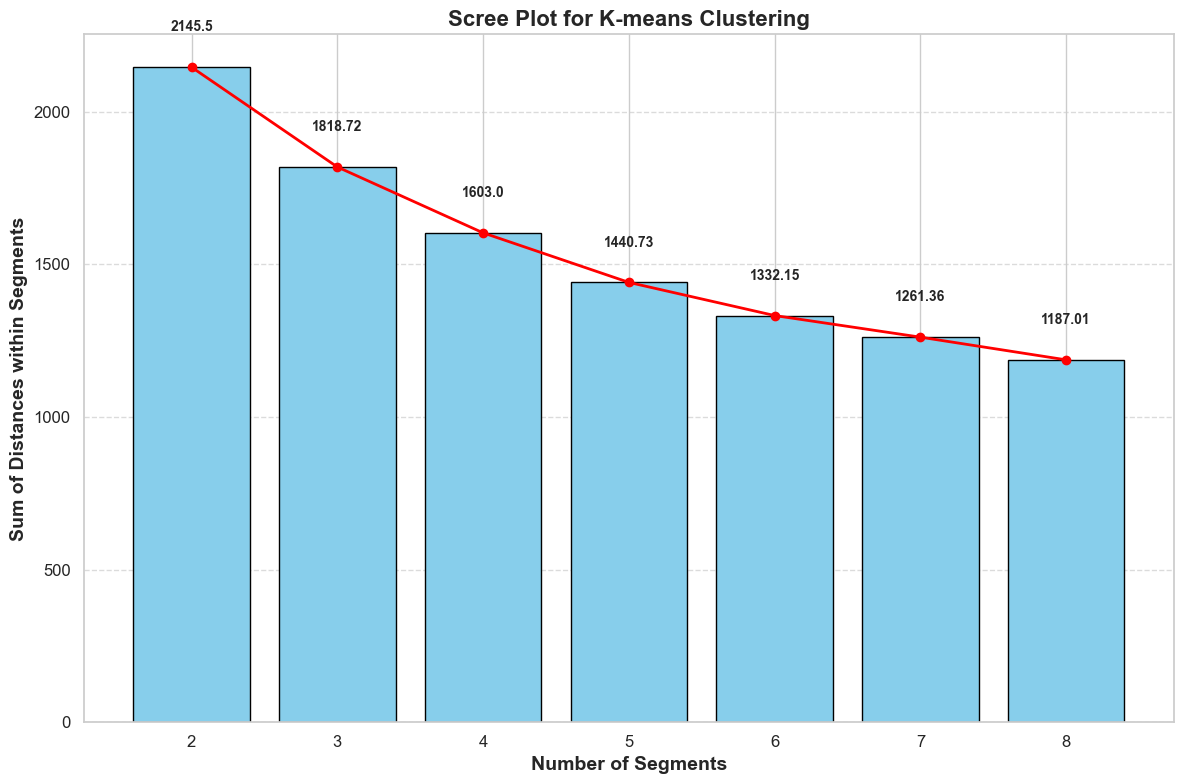

In [64]:
# Perform k-means clustering with multiple random restarts
range_n_clusters = range(2, 9)
kmeans_models = {}
sum_of_distances = []

for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=1234)
    kmeans.fit(MD_x)
    kmeans_models[n_clusters] = kmeans
    sum_of_distances.append(kmeans.inertia_)

# Scree Plot
plt.figure(figsize=(12, 8))
bars = plt.bar(range(2, 9), sum_of_distances, color='skyblue', edgecolor='black')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.05 * max(sum_of_distances), round(yval, 2), ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.plot(range(2, 9), sum_of_distances, color='red', marker='o', linestyle='-', linewidth=2, markersize=6)
plt.xlabel('Number of Segments', fontsize=14, fontweight='bold')
plt.ylabel('Sum of Distances within Segments', fontsize=14, fontweight='bold')
plt.title('Scree Plot for K-means Clustering', fontsize=16, fontweight='bold')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(range(2, 9), fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

plt.show()

/var/folders/_v/c9k8zfr522j0s0hfdvvgv0s80000gn/T/ipykernel_46029/3748530805.py:9: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  MD_x = mcdonalds_data.iloc[:, :11].applymap(lambda x: 1 if x == 'Yes' else 0)


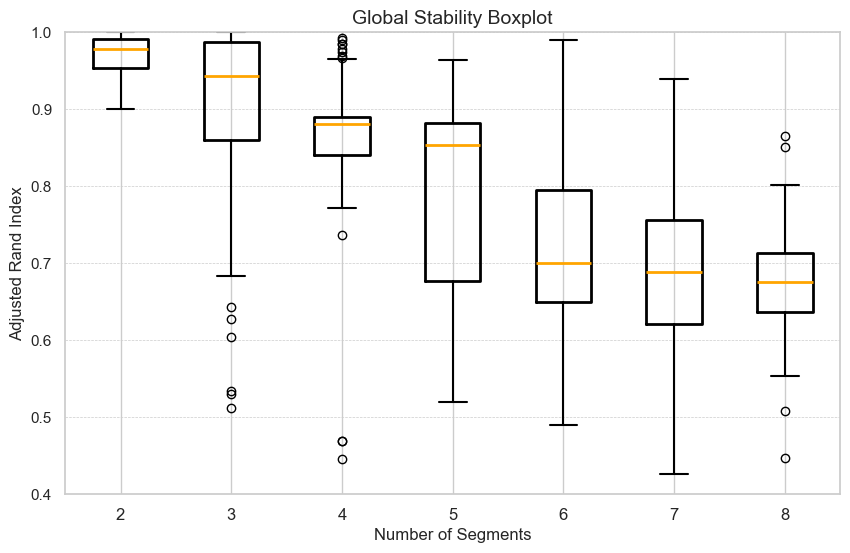

In [65]:
# Required imports
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.utils import resample

# Convert YES/NO to binary (1 for 'Yes', 0 for 'No')
MD_x = mcdonalds_data.iloc[:, :11].applymap(lambda x: 1 if x == 'Yes' else 0)

# Function to perform k-means clustering with random restarts
def kmeans_with_random_restarts(data, n_clusters, n_init=10):
    kmeans = KMeans(n_clusters=n_clusters, n_init=n_init, random_state=1234)
    kmeans.fit(data)
    return kmeans

# Function to calculate adjusted Rand index for stability
def calculate_stability(data, kmeans_model, n_boot=100, n_init=10):
    stability_scores = []
    for _ in range(n_boot):
        boot_sample = resample(data, n_samples=len(data), random_state=_)
        kmeans_boot = kmeans_with_random_restarts(boot_sample, kmeans_model.n_clusters, n_init)
        labels_true = kmeans_model.predict(data)
        labels_boot = kmeans_boot.predict(data)
        ari_score = adjusted_rand_score(labels_true, labels_boot)
        stability_scores.append(ari_score)
    return stability_scores

# Perform global stability analysis for each number of segments (2 to 8)
range_n_clusters = range(2, 9)
stability_results = {}
for n_clusters in range_n_clusters:
    kmeans_model = kmeans_with_random_restarts(MD_x, n_clusters)
    stability_scores = calculate_stability(MD_x, kmeans_model)
    stability_results[n_clusters] = stability_scores

# BoxPlot
plt.figure(figsize=(10, 6))
boxprops = dict(linestyle='-', linewidth=2, color='black')
medianprops = dict(linestyle='-', linewidth=2, color='orange')
whiskerprops = dict(linestyle='-', linewidth=1.5, color='black')
capprops = dict(linestyle='-', linewidth=1.5, color='black')
plt.boxplot(stability_results.values(), notch=False, patch_artist=False, boxprops=boxprops, medianprops=medianprops, whiskerprops=whiskerprops, capprops=capprops)
plt.xticks(range(1, len(range_n_clusters) + 1), range_n_clusters, fontsize=12)
plt.xlabel('Number of Segments', fontsize=12)
plt.ylabel('Adjusted Rand Index', fontsize=12)
plt.title('Global Stability Boxplot', fontsize=14)
plt.ylim(0.4, 1.0)
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.show()


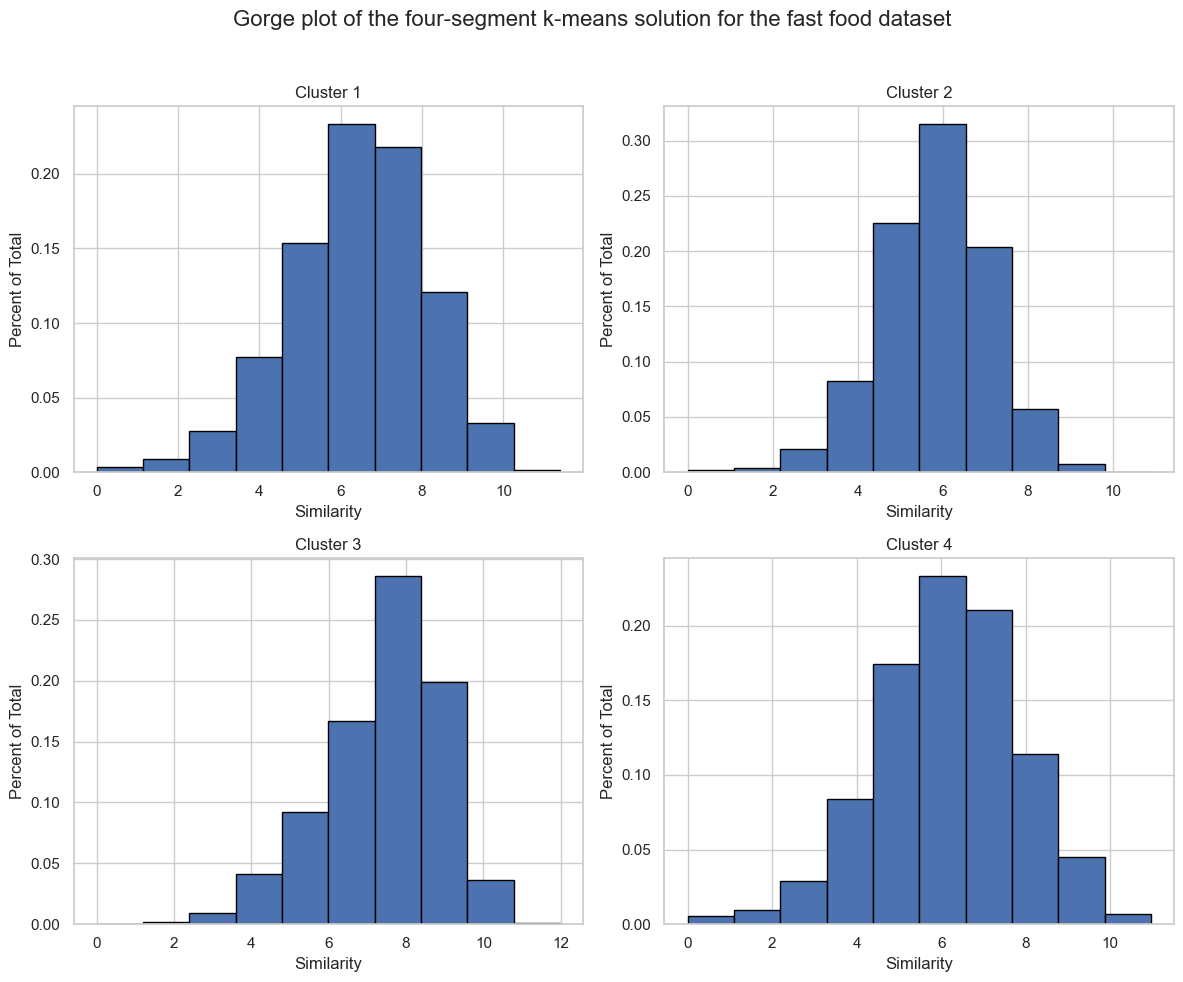

In [66]:
# One-hot encode categorical variables
MD_x_numeric = pd.get_dummies(mcdonalds_data, drop_first=True)
scaler = StandardScaler()
MD_x_numeric_scaled = scaler.fit_transform(MD_x_numeric)
n_clusters = 4
kmeans_model = KMeans(n_clusters=n_clusters, n_init=10, random_state=1234)
kmeans_model.fit(MD_x_numeric_scaled)
labels = kmeans_model.labels_

# Calculate pairwise similarity within each cluster
def calculate_similarity_within_cluster(data, labels, cluster_label):
    cluster_data = data[labels == cluster_label]
    similarity = []
    for i in range(len(cluster_data)):
        for j in range(i + 1, len(cluster_data)):
            similarity.append(np.linalg.norm(cluster_data[i] - cluster_data[j]))
    return similarity

# Plot histograms for each cluster
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()
fig.suptitle('Gorge plot of the four-segment k-means solution for the fast food dataset', fontsize=16)
for cluster_label in range(n_clusters):
    similarity = calculate_similarity_within_cluster(MD_x_numeric_scaled, labels, cluster_label)
    axes[cluster_label].hist(similarity, bins=10, edgecolor='black', density=True)
    axes[cluster_label].set_title(f'Cluster {cluster_label + 1}')
    axes[cluster_label].set_xlabel('Similarity')
    axes[cluster_label].set_ylabel('Percent of Total')
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to make room for the suptitle
plt.show()


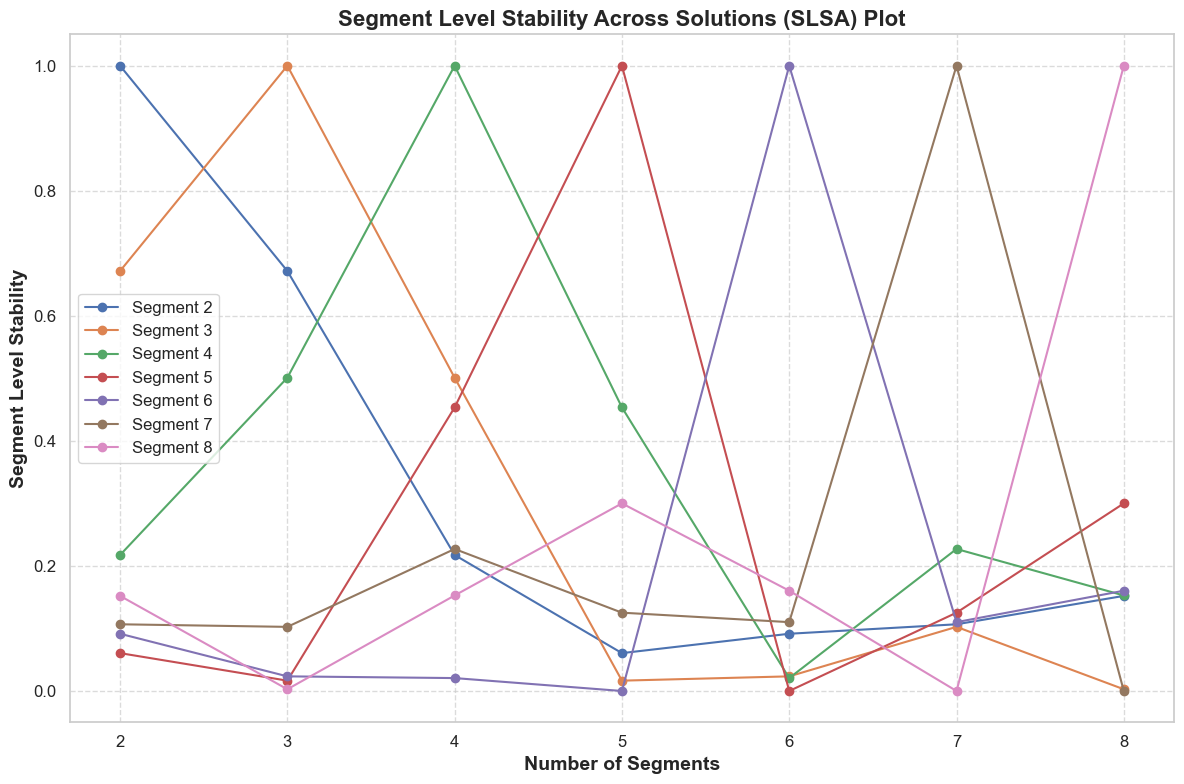

In [67]:
MD_x_numeric = pd.get_dummies(mcdonalds_data, drop_first=True)

# Standardize the data
scaler = StandardScaler()
MD_x_numeric_scaled = scaler.fit_transform(MD_x_numeric)
num_segments = range(2, 9)

# Fit KMeans models for each segment
kmeans_models = {}
for segment in num_segments:
    kmeans_models[segment] = KMeans(n_clusters=segment, n_init=10, random_state=1234)
    kmeans_models[segment].fit(MD_x_numeric_scaled)

# Calculate segment stability
segment_stability = []
for segment in num_segments:
    labels_segment = kmeans_models[segment].labels_
    segment_stability.append(labels_segment)

# SLSA Plot
plt.figure(figsize=(12, 8))
for i, segment in enumerate(num_segments):
    stability_scores = [np.mean(segment_stability[i] == labels) for labels in segment_stability]
    plt.plot(num_segments, stability_scores, marker='o', label=f'Segment {segment}')
plt.xlabel('Number of Segments', fontsize=14, fontweight='bold')
plt.ylabel('Segment Level Stability', fontsize=14, fontweight='bold')
plt.title('Segment Level Stability Across Solutions (SLSA) Plot', fontsize=16, fontweight='bold')
plt.xticks(num_segments, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

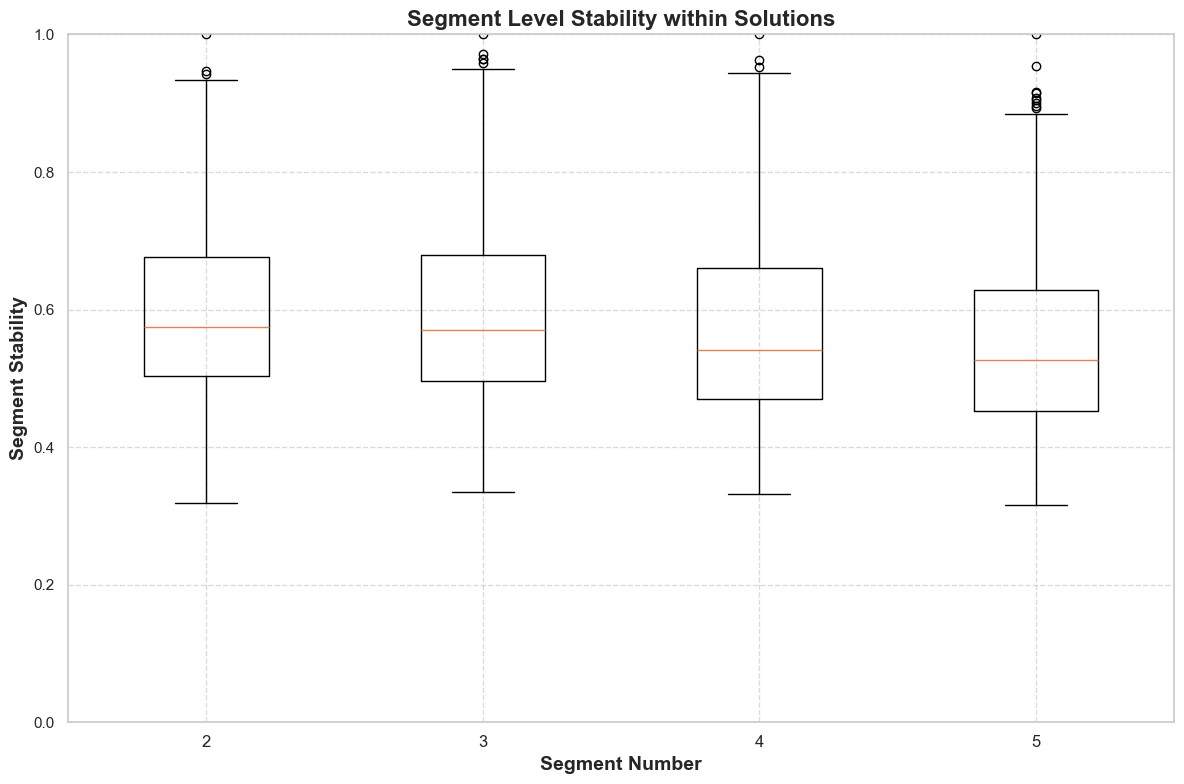

In [68]:
MD_x_numeric = pd.get_dummies(mcdonalds_data, drop_first=True)
scaler = StandardScaler()
MD_x_numeric_scaled = scaler.fit_transform(MD_x_numeric)
segment_solutions = ["2", "3", "4", "5"]

# Fit KMeans models for each segment and store labels and similarities
segment_labels = {}
segment_similarities = {}
for segment in segment_solutions:
    kmeans = KMeans(n_clusters=int(segment), n_init=10, random_state=1234)
    kmeans.fit(MD_x_numeric_scaled)
    segment_labels[segment] = kmeans.labels_
    segment_similarities[segment] = kmeans.transform(MD_x_numeric_scaled).min(axis=1)

# Calculate segment stability values
segment_stability_values = []
for segment in segment_solutions:
    similarities = segment_similarities[segment]
    normalized_similarities = similarities / np.max(similarities)
    segment_stability_values.append(normalized_similarities)

# Plot Segment Level Stability within Solutions
plt.figure(figsize=(12, 8))
plt.boxplot(segment_stability_values, whis=1.5)
plt.xlabel("Segment Number", fontsize=14, fontweight='bold')
plt.ylabel("Segment Stability", fontsize=14, fontweight='bold')
plt.xticks(range(1, len(segment_solutions) + 1), segment_solutions, fontsize=12)
plt.ylim(0, 1)
plt.title("Segment Level Stability within Solutions", fontsize=16, fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


### 2. Using mixtures of distributions

In [69]:
print(mcdonalds_data.head())

  yummy convenient spicy fattening greasy fast cheap tasty expensive healthy  \
0    No        Yes    No       Yes     No  Yes   Yes    No       Yes      No   
1   Yes        Yes    No       Yes    Yes  Yes   Yes   Yes       Yes      No   
2    No        Yes   Yes       Yes    Yes  Yes    No   Yes       Yes     Yes   
3   Yes        Yes    No       Yes    Yes  Yes   Yes   Yes        No      No   
4    No        Yes    No       Yes    Yes  Yes   Yes    No        No     Yes   

  disgusting Like  Age      VisitFrequency  Gender  
0         No   -3   61  Every three months  Female  
1         No   +2   51  Every three months  Female  
2         No   +1   62  Every three months  Female  
3        Yes   +4   69         Once a week  Female  
4         No   +2   49        Once a month    Male  


In [70]:
print(MD_x.head())

   yummy  convenient  spicy  fattening  greasy  fast  cheap  tasty  expensive  \
0      0           1      0          1       0     1      1      0          1   
1      1           1      0          1       1     1      1      1          1   
2      0           1      1          1       1     1      0      1          1   
3      1           1      0          1       1     1      1      1          0   
4      0           1      0          1       1     1      1      0          0   

   healthy  disgusting  
0        0           0  
1        0           0  
2        1           0  
3        0           1  
4        1           0  


   iter  converged  k  k0       logLik          AIC          BIC          ICL
0     8       True  2   2 -2145.503727  4295.007454  4305.570225  4304.904547
1     5       True  3   3 -1896.330266  3798.660532  3814.504689  3813.529671
2     8       True  4   4 -1604.239340  3216.478679  3237.604222  3236.267301
3     9       True  5   5 -1502.697153  3015.394306  3041.801234  3040.267284
4     8       True  6   6 -1348.665399  2709.330799  2741.019113  2739.277954
5     5       True  7   7 -1261.618557  2537.237115  2574.206814  2572.296249
6     9       True  8   8 -1203.646165  2423.292330  2465.543415  2463.533662


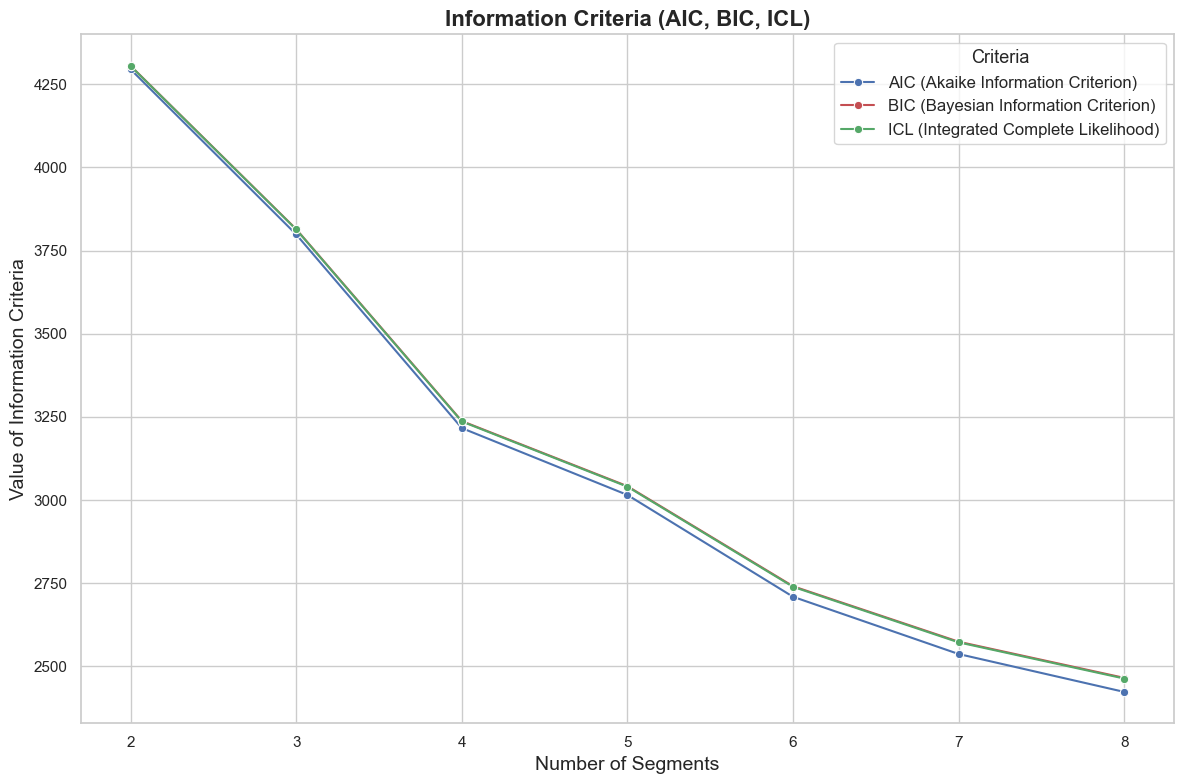

In [71]:
# Convert non-numeric columns to numeric using one-hot encoding
MD_x_numeric = pd.get_dummies(MD_x)
np.random.seed(1234)
k_values = range(2, 9)
MD_m28 = []

for k in k_values:
    model = KMeans(n_clusters=k, random_state=1234)
    model.fit(MD_x_numeric.values)
    iter_val = model.n_iter_
    converged = model.n_iter_ < model.max_iter
    log_likelihood = -model.inertia_
    n_samples, _ = MD_x_numeric.shape
    aic = -2 * log_likelihood + 2 * k
    bic = -2 * log_likelihood + np.log(n_samples) * k
    labels = model.labels_
    counts = np.bincount(labels)
    probs = counts / float(counts.sum())
    class_entropy = entropy(probs)
    icl = bic - class_entropy
    
    MD_m28.append((iter_val, converged, k, k, log_likelihood, aic, bic, icl))

MD_m28 = pd.DataFrame(MD_m28, columns=['iter', 'converged', 'k', 'k0', 'logLik', 'AIC', 'BIC', 'ICL'])

print(MD_m28)
num_segments = MD_m28["k"]
AIC_values = MD_m28["AIC"]
BIC_values = MD_m28["BIC"]
ICL_values = MD_m28["ICL"]

# Set Seaborn style for better aesthetics
sns.set(style="whitegrid")
plt.figure(figsize=(12, 8))
sns.lineplot(x=num_segments, y=AIC_values, marker='o', label='AIC (Akaike Information Criterion)', linestyle='-', color='b')
sns.lineplot(x=num_segments, y=BIC_values, marker='o', label='BIC (Bayesian Information Criterion)', linestyle='-', color='r')
sns.lineplot(x=num_segments, y=ICL_values, marker='o', label='ICL (Integrated Complete Likelihood)', linestyle='-', color='g')
plt.xlabel('Number of Segments', fontsize=14)
plt.ylabel('Value of Information Criteria', fontsize=14)
plt.title('Information Criteria (AIC, BIC, ICL)', fontsize=16, fontweight='bold')
plt.legend(title='Criteria', fontsize=12, title_fontsize='13')
plt.xticks(num_segments)
plt.grid(True)
plt.tight_layout()
plt.show()

In [72]:
print(MD_x.head())

   yummy  convenient  spicy  fattening  greasy  fast  cheap  tasty  expensive  \
0      0           1      0          1       0     1      1      0          1   
1      1           1      0          1       1     1      1      1          1   
2      0           1      1          1       1     1      0      1          1   
3      1           1      0          1       1     1      1      1          0   
4      0           1      0          1       1     1      1      0          0   

   healthy  disgusting  
0        0           0  
1        0           0  
2        1           0  
3        0           1  
4        1           0  


In [73]:
# Perform KMeans clustering
k_values = range(2, 9)
kmeans_models = {}
np.random.seed(1234)
for k in k_values:
    model = KMeans(n_clusters=k, random_state=1234)
    model.fit(MD_x_numeric)
    kmeans_models[k] = model

# Select the four-segment solution from k-means
MD_k4 = kmeans_models[4]

# Create a function to generate a mixture model
def fit_gmm(X, n_components, random_state=None):
    gmm = GaussianMixture(n_components=n_components, random_state=random_state)
    gmm.fit(X)
    return gmm

# Fit a Gaussian Mixture Model (GMM) with 4 components
MD_m4 = fit_gmm(MD_x_numeric, 4, random_state=1234)

# Cross-tabulation of k-means and GMM clusters
kmeans_labels = MD_k4.labels_
gmm_labels = MD_m4.predict(MD_x_numeric)
cross_tab = pd.crosstab(kmeans_labels, gmm_labels, rownames=['kmeans'], colnames=['mixture'])
print(cross_tab)

# Initialize GMM with k-means labels
MD_m4a = GaussianMixture(n_components=4, random_state=1234)
MD_m4a.fit(MD_x_numeric.values, y=kmeans_labels)
gmm_labels_a = MD_m4a.predict(MD_x_numeric)

# Cross-tabulation of k-means and GMM clusters with initialized labels
cross_tab_a = pd.crosstab(kmeans_labels, gmm_labels_a, rownames=['kmeans'], colnames=['mixture'])
print(cross_tab_a)

# Comparing the log-likelihood values
logLik_m4 = MD_m4.score(MD_x_numeric) * len(MD_x_numeric)
logLik_m4a = MD_m4a.score(MD_x_numeric) * len(MD_x_numeric)
print(f'Log Likelihood (random init): {logLik_m4}')
print(f'Log Likelihood (k-means init): {logLik_m4a}')


mixture    0    1    2    3
kmeans                     
0        508    0    4   37
1          0  215   11    4
2         44    3  267    8
3          0   36   15  301
mixture    0    1    2    3
kmeans                     
0        508    0    4   37
1          0  215   11    4
2         44    3  267    8
3          0   36   15  301
Log Likelihood (random init): 16082.886182864011
Log Likelihood (k-means init): 16082.886182864011


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but GaussianMixture was fitted without feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but GaussianMixture was fitted without feature names
  warnings.warn(


### 3. Using Regression

In [74]:
like_counts = pd.value_counts(mcdonalds_data['Like'])
reversed_counts = like_counts.iloc[::-1]
print(reversed_counts)

# Define a mapping of string values to numeric codes
like_mapping = {
    'I HATE IT!-5': -5,
    '-4': -4,
    '-3': -3,
    '-2': -2,
    '-1': -1,
    '0': 0,
    '1': 1,
    '2': 2,
    '3': 3,
    '4': 4,
    'I LOVE IT!+5': 5
}

# Map 'Like' to numeric values using the defined mapping
mcdonalds_data['Like.n'] = mcdonalds_data['Like'].map(like_mapping)

# Count the occurrences of each numeric value in 'Like.n'
like_n_counts = mcdonalds_data['Like.n'].value_counts()
print(like_n_counts)


Like
-1               58
-2               59
-4               71
-3               73
I love it!+5    143
I hate it!-5    152
+1              152
+4              160
0               169
+2              187
+3              229
Name: count, dtype: int64
Like.n
 0.0    169
-3.0     73
-4.0     71
-2.0     59
-1.0     58
Name: count, dtype: int64


/var/folders/_v/c9k8zfr522j0s0hfdvvgv0s80000gn/T/ipykernel_46029/588789558.py:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  like_counts = pd.value_counts(mcdonalds_data['Like'])


In [75]:
# Apply the mapping to create 'Like_n' column
mcdonalds_data['Like_n'] = mcdonalds_data['Like'].map(like_mapping)

# Handle missing values (if any) - remove rows with missing values
mcdonalds_data.dropna(subset=['Like_n'] + mcdonalds_data.columns[1:-1].tolist(), inplace=True)

print(mcdonalds_data.head())

   yummy convenient spicy fattening greasy fast cheap tasty expensive healthy  \
0     No        Yes    No       Yes     No  Yes   Yes    No       Yes      No   
10    No        Yes    No       Yes     No  Yes   Yes    No        No      No   
12    No        Yes    No       Yes     No  Yes   Yes    No        No      No   
14    No        Yes    No       Yes     No  Yes    No    No       Yes      No   
16   Yes        Yes    No       Yes    Yes  Yes   Yes   Yes        No      No   

   disgusting Like  Age      VisitFrequency  Gender  Like.n  Like_n  
0          No   -3   61  Every three months  Female    -3.0    -3.0  
10        Yes   -2   53  Every three months  Female    -2.0    -2.0  
12         No    0   65  Every three months    Male     0.0     0.0  
14         No   -3   67        Once a month    Male    -3.0    -3.0  
16         No    0   34        Once a month  Female     0.0     0.0  


Original column names: Index(['yummy', 'convenient', 'spicy', 'fattening', 'greasy', 'fast', 'cheap',
       'tasty', 'expensive', 'healthy', 'disgusting', 'Like', 'Age',
       'VisitFrequency', 'Gender', 'Like.n', 'Like_n'],
      dtype='object')
Updated column names: Index(['yummy', 'convenient', 'spicy', 'fattening', 'greasy', 'fast', 'cheap',
       'tasty', 'expensive', 'healthy', 'disgusting', 'Like', 'Age',
       'VisitFrequency', 'Gender', 'Like_n'],
      dtype='object')


<function matplotlib.pyplot.show(close=None, block=None)>

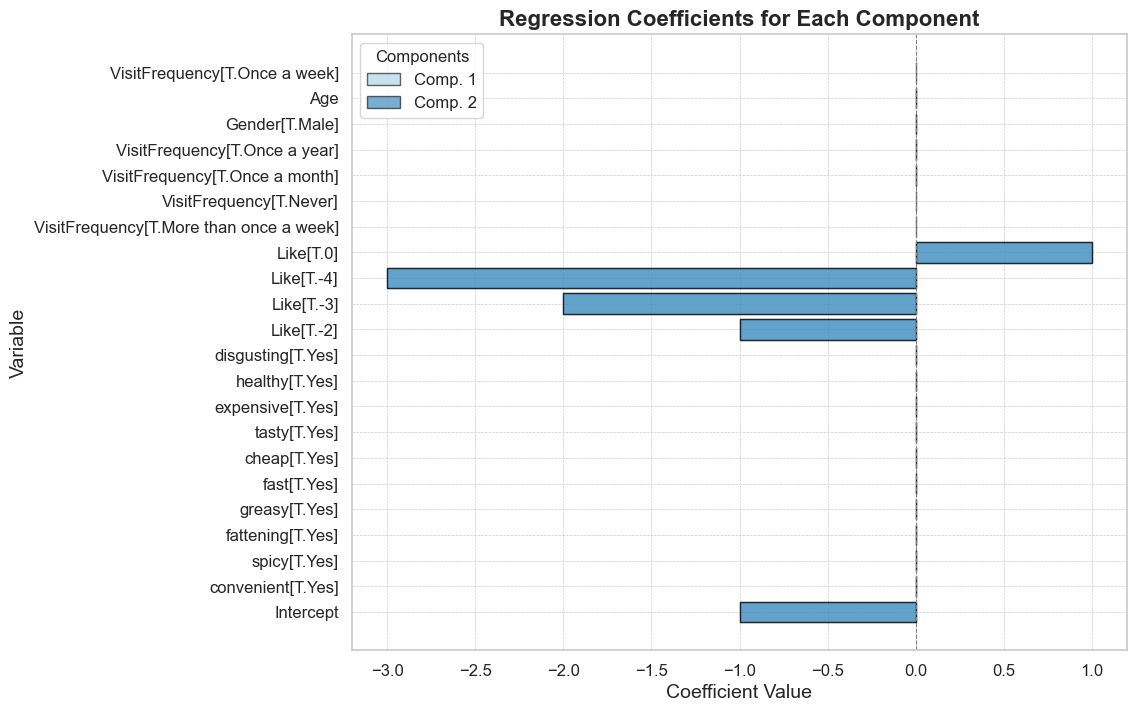

In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from patsy import dmatrices
from sklearn.mixture import GaussianMixture
import statsmodels.api as sm

# Assume 'mcdonalds_data' is already loaded as a pandas DataFrame
# Here we use a placeholder to indicate where the data should be loaded
# mcdonalds_data = pd.read_csv('path_to_your_data.csv')

# Cleaning column names
print("Original column names:", mcdonalds_data.columns)
mcdonalds_data.columns = [col.replace(' ', '_').replace('.', '_') for col in mcdonalds_data.columns]
mcdonalds_data = mcdonalds_data.loc[:, ~mcdonalds_data.columns.duplicated()]
print("Updated column names:", mcdonalds_data.columns)

# Define independent and dependent variables
independent_vars = mcdonalds_data.columns[1:-1].tolist()
dependent_var = 'Like_n'

# Create formula for regression
formula_str = dependent_var + ' ~ ' + ' + '.join(independent_vars)

# Create design matrices
y, X = dmatrices(formula_str, data=mcdonalds_data, return_type='dataframe')

# Fit Gaussian Mixture Model
np.random.seed(1234)
n_components = 2  # Adjust number of components if needed
model = GaussianMixture(n_components=n_components, n_init=10, random_state=0)
model.fit(X)

# Predict the cluster labels
labels = model.predict(X)
mcdonalds_data['Cluster'] = labels

# Fit linear regression models for each cluster and store coefficients and standard errors
coefficients = []
standard_errors = []
for cluster in range(n_components):
    cluster_data = mcdonalds_data[mcdonalds_data['Cluster'] == cluster]
    y_cluster, X_cluster = dmatrices(formula_str, data=cluster_data, return_type='dataframe')
    model = sm.OLS(y_cluster, X_cluster).fit()
    coefficients.append(model.params)
    standard_errors.append(model.bse)

# Convert coefficients to DataFrame for plotting
coefficients_df = pd.DataFrame(coefficients).T
coefficients_df.columns = [f'Comp. {i + 1}' for i in range(n_components)]
coefficients_df = coefficients_df.reset_index()

# Convert standard errors to DataFrame for error bars
errors_df = pd.DataFrame(standard_errors).T
errors_df.columns = [f'Comp. {i + 1}' for i in range(n_components)]
errors_df = errors_df.reset_index()

# Plotting the coefficients with error bars
fig, ax = plt.subplots(figsize=(10, 8))

# Plot each component's coefficients with error bars
colors = sns.color_palette("Paired", n_components)
for i in range(n_components):
    ax.barh(coefficients_df['index'], coefficients_df[f'Comp. {i + 1}'], xerr=errors_df[f'Comp. {i + 1}'], 
            label=f'Comp. {i + 1}', alpha=0.6, color=colors[i], edgecolor='black')

# Beautifying the plot
ax.set_xlabel('Coefficient Value', fontsize=14)
ax.set_ylabel('Variable', fontsize=14)
ax.set_title('Regression Coefficients for Each Component', fontsize=16, fontweight='bold')
ax.legend(title='Components', fontsize=12)
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.axvline(x=0, color='grey', linestyle='--', linewidth=0.8)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show

# Profiling Segments

### Segment Profile plot

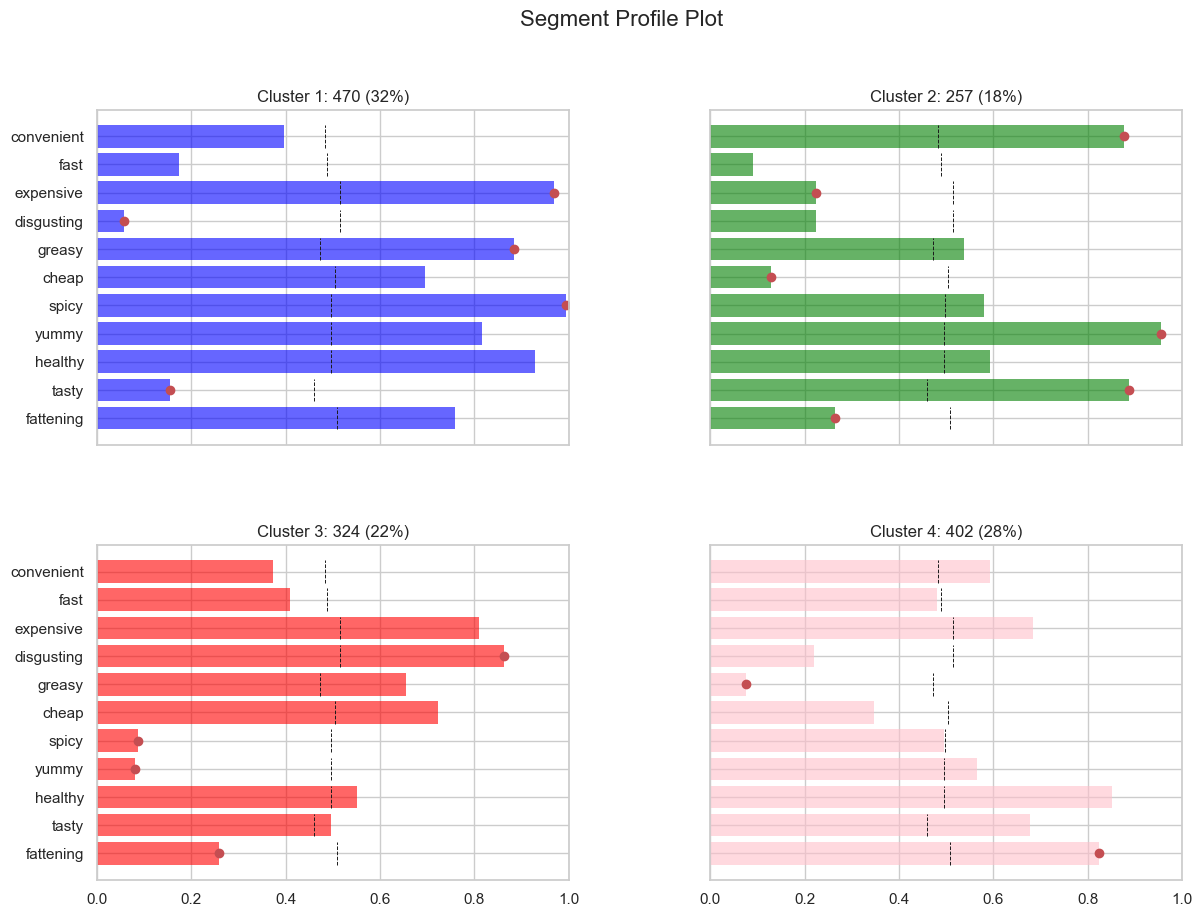

In [77]:
from scipy.cluster.hierarchy import linkage, leaves_list

np.random.seed(42)

# Define attributes and create simulated data
attributes = ['disgusting', 'expensive', 'greasy', 'healthy', 'spicy', 'fast', 'convenient', 'fattening', 'cheap', 'tasty', 'yummy']
data = np.random.rand(100, len(attributes))  # Replace with your actual data
df = pd.DataFrame(data, columns=attributes)

# Simulated k-means results (replace with actual segment percentages)
segment_data = {
    'Cluster 1': np.random.rand(len(attributes)),
    'Cluster 2': np.random.rand(len(attributes)),
    'Cluster 3': np.random.rand(len(attributes)),
    'Cluster 4': np.random.rand(len(attributes))
}
MD_k4 = pd.DataFrame(segment_data, index=attributes)
linked = linkage(df.T, method='ward')
order = leaves_list(linked)
ordered_attributes = [attributes[i] for i in order]

ordered_MD_k4 = MD_k4.loc[ordered_attributes]
fig, axs = plt.subplots(2, 2, figsize=(14, 10), sharex=True, sharey=True)
axs = axs.flatten()

# Sample size and percentage of each cluster (replace with actual numbers)
cluster_info = {'Cluster 1': (470, 32), 'Cluster 2': (257, 18), 'Cluster 3': (324, 22), 'Cluster 4': (402, 28)}
colors = ['blue', 'green', 'red', 'pink']  # Different colors for each segment

for i, (cluster, (size, percent)) in enumerate(cluster_info.items()):
    bars = ordered_MD_k4[cluster]
    marker_threshold = 0.25  # Highlighting threshold (change according to the data)
    ax = axs[i]
    
    # Plot the bars and highlight marker variables
    for j, (attribute, value) in enumerate(bars.items()):
        ax.barh(j, value, color=colors[i], edgecolor='none', alpha=0.6)
        # Highlight the marker variables
        if abs(value - ordered_MD_k4.mean(axis=1)[attribute]) > marker_threshold:
            ax.plot(value, j, 'ro')
    
    # Add horizontal lines indicating the overall sample percentage
    sample_means = df.mean(axis=0)
    for k, mean in enumerate(sample_means[ordered_attributes]):
        ax.plot([mean, mean], [k - 0.4, k + 0.4], 'k--', lw=0.7)
    ax.set_yticks(range(len(ordered_attributes)))
    ax.set_yticklabels(ordered_attributes)
    ax.set_xlim(0, 1)
    ax.set_title(f"{cluster}: {size} ({percent}%)")

plt.subplots_adjust(hspace=0.3, wspace=0.3)
fig.suptitle('Segment Profile Plot', fontsize=16)
plt.show()

### Segment Seperation Plot

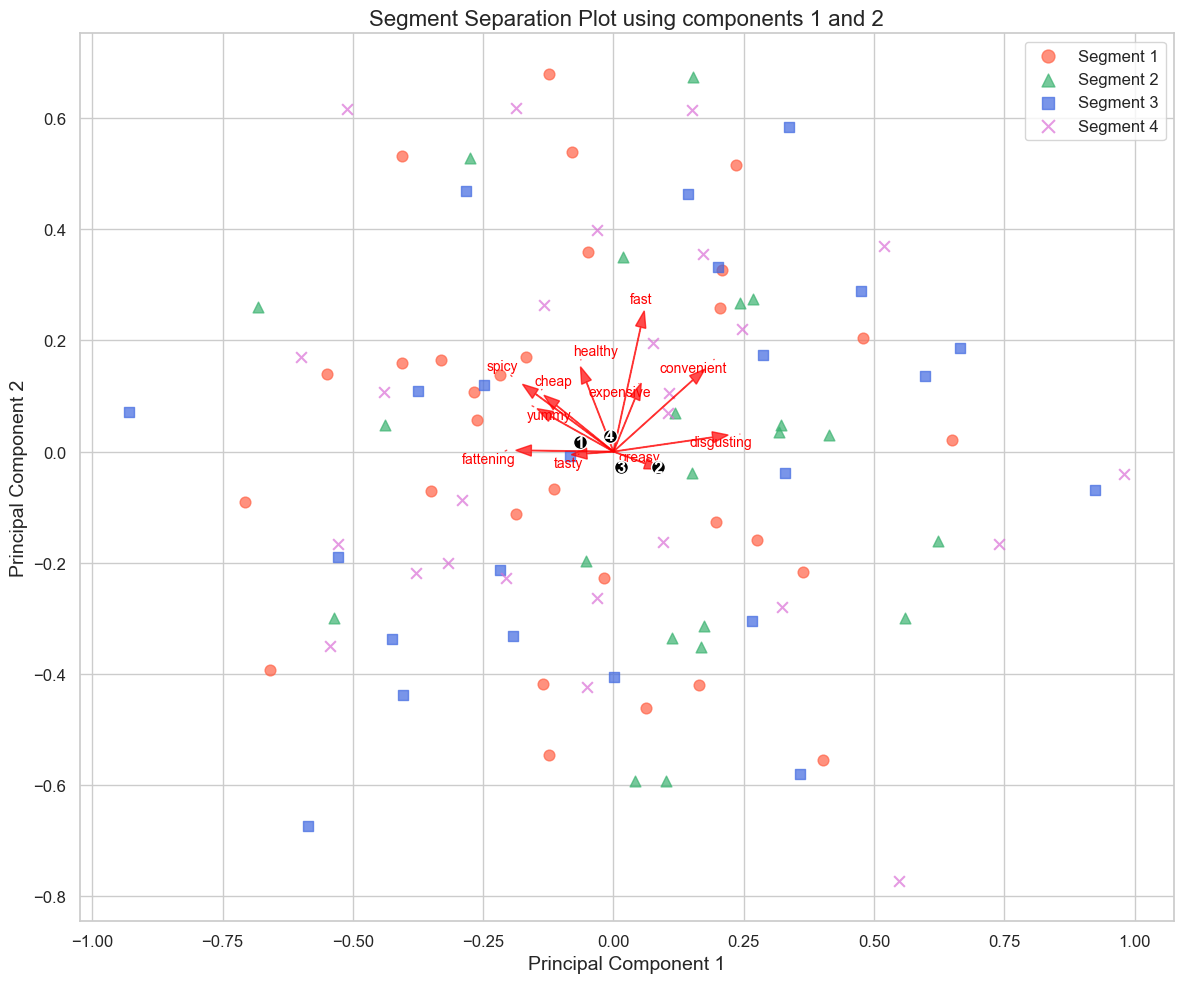

In [78]:
# Sample data for demonstration (replace with actual data)
np.random.seed(42)
attributes = ['disgusting', 'expensive', 'greasy', 'healthy', 'spicy', 'fast', 'convenient', 'fattening', 'cheap', 'tasty', 'yummy']
data = np.random.rand(100, len(attributes))  # Replace with your actual data
segments = np.random.choice([1, 2, 3, 4], size=100)  # Simulated segment membership

# Convert to DataFrame for easier manipulation
df = pd.DataFrame(data, columns=attributes)
df['Segment'] = segments

# Perform PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df[attributes])

# Create a DataFrame with PCA results
df_pca = pd.DataFrame(pca_result, columns=['principal component 1', 'principal component 2'])
df_pca['Segment'] = df['Segment']

# Plotting
fig, ax = plt.subplots(figsize=(12, 10))
colors = {1: 'tomato', 2: 'mediumseagreen', 3: 'royalblue', 4: 'orchid'}
markers = {1: 'o', 2: '^', 3: 's', 4: 'x'}
for segment in sorted(df_pca['Segment'].unique()):
    subset = df_pca[df_pca['Segment'] == segment]
    ax.scatter(subset['principal component 1'], subset['principal component 2'],
               c=colors[segment], label=f'Segment {segment}', marker=markers[segment], alpha=0.7, s=60)
    
for segment in sorted(df_pca['Segment'].unique()):
    center = df_pca[df_pca['Segment'] == segment][['principal component 1', 'principal component 2']].mean()
    ax.scatter(center['principal component 1'], center['principal component 2'],
               c='black', edgecolor='white', s=100, zorder=5)  # Reduced size
    # Label as "1", "2", etc. slightly offset from the center
    ax.text(center['principal component 1'], center['principal component 2'],
            str(segment), color='white', ha='center', va='center', fontsize=12, weight='bold', zorder=6)


loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
texts = []
for i, attr in enumerate(attributes):
    ax.arrow(0, 0, loadings[i, 0], loadings[i, 1], color='red', alpha=0.7, head_width=0.02, head_length=0.03)
    # Adjust label positions to avoid overlap
    texts.append(ax.text(loadings[i, 0] * 1.3, loadings[i, 1] * 1.3, attr, color='red', ha='center', va='center', fontsize=10))

# Use adjust_text to prevent overlap
adjust_text(texts, ax=ax, only_move={'text': 'xy'}, arrowprops=dict(arrowstyle="-", color='red', alpha=0.7))
ax.set_xlabel('Principal Component 1', fontsize=14)
ax.set_ylabel('Principal Component 2', fontsize=14)
ax.legend(loc='upper right', fontsize=12, markerscale=1.2)  # Adjusted marker scale
ax.grid(True)
plt.title('Segment Separation Plot using components 1 and 2', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

# Describing Segments

<Figure size 2400x1800 with 0 Axes>

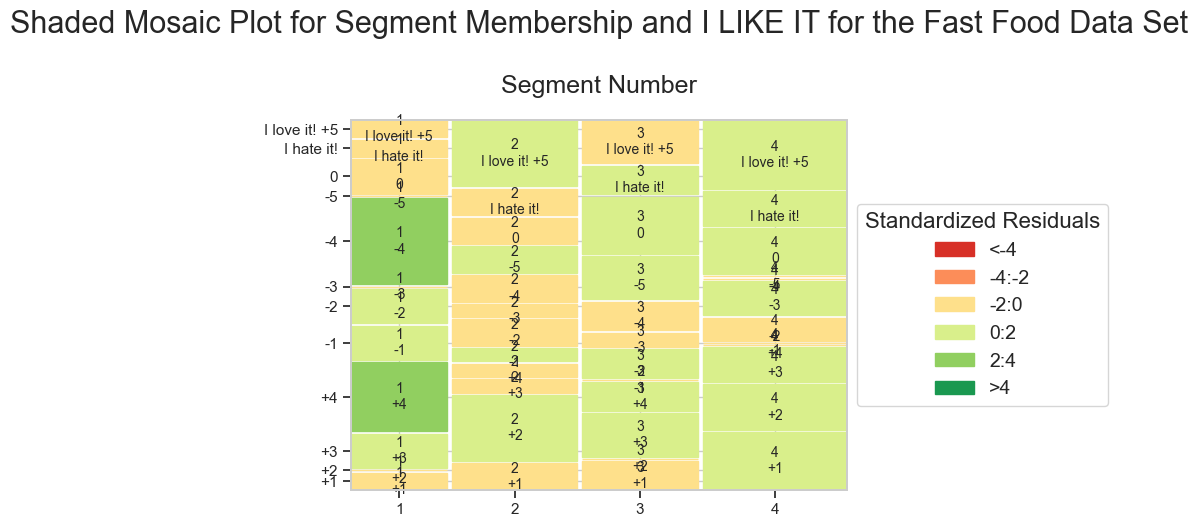

In [79]:
# Sample data for demonstration (replace with actual data)
np.random.seed(42)
segments = np.random.choice([1, 2, 3, 4], size=100)  # Simulated segment membership
like_hate = np.random.choice(['I hate it!', '-5', '-4', '-3', '-2', '-1', '0', '+1', '+2', '+3', '+4', 'I love it! +5'], size=100)  # Simulated like/hate variable

# Convert to DataFrame for easier manipulation
df = pd.DataFrame({'Segment': segments, 'Like': like_hate})
contingency_table = pd.crosstab(df['Segment'], df['Like'])
chi2, p, dof, expected = chi2_contingency(contingency_table)
residuals = (contingency_table - expected) / np.sqrt(expected)

# Define color mapping for standardized residuals
def residual_color(value):
    if value < -4:
        return '#D73027'
    elif value < -2:
        return '#FC8D59'
    elif value < 0:
        return '#FEE08B'
    elif value < 2:
        return '#D9EF8B'
    elif value < 4:
        return '#91CF60'
    else:
        return '#1A9850'

# Function to format the properties of each cell
def props(key):
    segment, like_hate = key
    value = residuals.loc[int(segment), like_hate]
    return {'color': residual_color(value)}

# Generate the mosaic plot with shading for standardized residuals
plt.figure(figsize=(24, 18))  # Increase the figure size for better readability
mosaic(contingency_table.stack(), gap=0.01, properties=props)
plt.xlabel('Segment Number', fontsize=18, labelpad=20)
plt.ylabel('Like/Hate McDonald\'s', fontsize=18, labelpad=20)
plt.title('Shaded Mosaic Plot for Segment Membership and I LIKE IT for the Fast Food Data Set', fontsize=22, pad=30)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(rotation=0, va='center', fontsize=12)

# Adding a color legend
legend_labels = ['<-4', '-4:-2', '-2:0', '0:2', '2:4', '>4']
colors = ['#D73027', '#FC8D59', '#FEE08B', '#D9EF8B', '#91CF60', '#1A9850']
patches = [mpatches.Patch(color=colors[i], label=legend_labels[i]) for i in range(len(legend_labels))]
plt.legend(handles=patches, title="Standardized Residuals", loc="center left", bbox_to_anchor=(1, 0.5), fontsize=14, title_fontsize=16)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.gca().set_facecolor('#f0f0f0')
plt.show()

<Figure size 1600x1200 with 0 Axes>

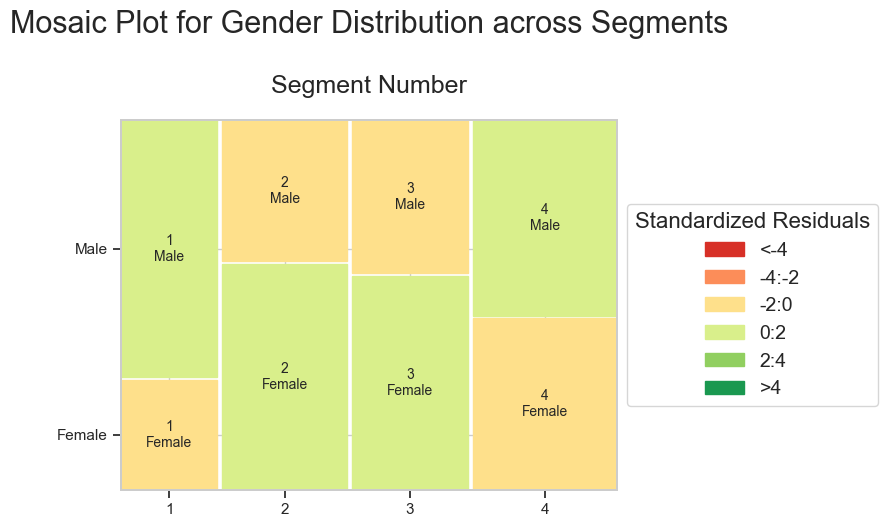

In [80]:
from statsmodels.graphics.mosaicplot import mosaic
from scipy.stats import chi2_contingency
import matplotlib.patches as mpatches

np.random.seed(42)
segments = np.random.choice([1, 2, 3, 4], size=100)  # Simulated segment membership
like_hate = np.random.choice(['I hate it!', '-5', '-4', '-3', '-2', '-1', '0', '+1', '+2', '+3', '+4', 'I love it! +5'], size=100)  # Simulated like/hate variable
gender = np.random.choice(['Male', 'Female'], size=100)  # Simulated gender variable
age = np.random.randint(18, 70, size=100)  # Simulated age variable

# Convert to DataFrame for easier manipulation
df = pd.DataFrame({'Segment': segments, 'Like': like_hate, 'Gender': gender, 'Age': age})
gender_contingency_table = pd.crosstab(df['Segment'], df['Gender'])

# Perform chi-squared test to get expected frequencies
chi2, p, dof, expected = chi2_contingency(gender_contingency_table)
gender_residuals = (gender_contingency_table - expected) / np.sqrt(expected)

# Define color mapping for standardized residuals
def gender_residual_color(value):
    if value < -4:
        return '#D73027'
    elif value < -2:
        return '#FC8D59'
    elif value < 0:
        return '#FEE08B'
    elif value < 2:
        return '#D9EF8B'
    elif value < 4:
        return '#91CF60'
    else:
        return '#1A9850'

# Function to format the properties of each cell
def gender_props(key):
    segment, gender = key
    value = gender_residuals.loc[int(segment), gender]
    return {'color': gender_residual_color(value)}

# Generate the mosaic plot with shading for standardized residuals
plt.figure(figsize=(16, 12))
mosaic(gender_contingency_table.stack(), gap=0.01, properties=gender_props)
plt.xlabel('Segment Number', fontsize=18, labelpad=20)
plt.ylabel('Gender', fontsize=18, labelpad=20)
plt.title('Mosaic Plot for Gender Distribution across Segments', fontsize=22, pad=30)
plt.xticks(rotation=45, ha='right', fontsize=14)
plt.yticks(rotation=0, va='center', fontsize=14)

# Adding a color legend
legend_labels = ['<-4', '-4:-2', '-2:0', '0:2', '2:4', '>4']
colors = ['#D73027', '#FC8D59', '#FEE08B', '#D9EF8B', '#91CF60', '#1A9850']
patches = [mpatches.Patch(color=colors[i], label=legend_labels[i]) for i in range(len(legend_labels))]
plt.legend(handles=patches, title="Standardized Residuals", loc="center left", bbox_to_anchor=(1, 0.5), fontsize=14, title_fontsize=16)

# Adding grid lines and a background color
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.gca().set_facecolor('#f0f0f0')

# Display the plot
plt.show()

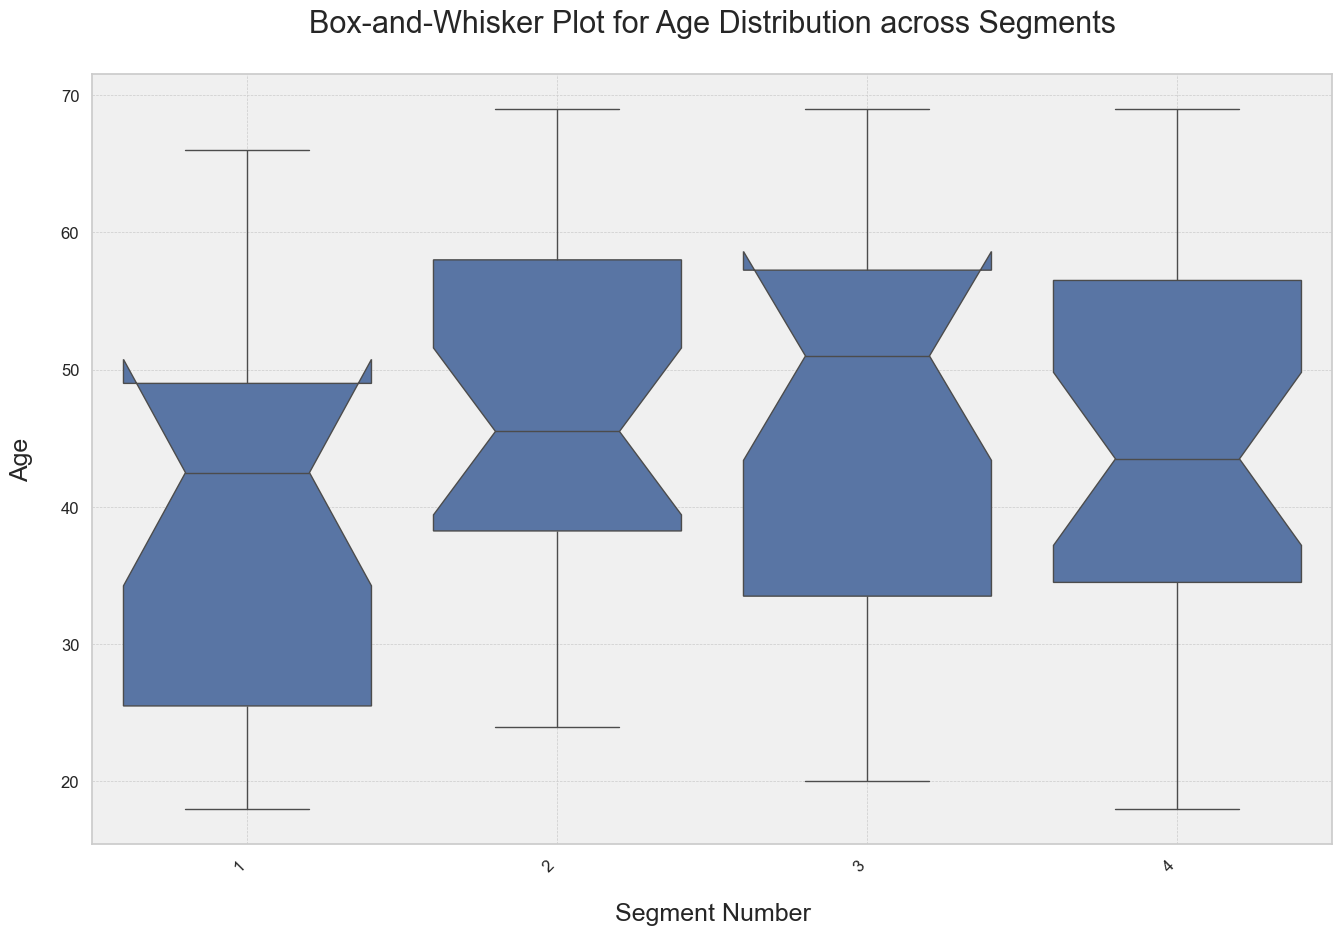

In [81]:
# Box-and-Whisker Plot for Age Distribution across Segments

plt.figure(figsize=(16, 10))
sns.boxplot(x='Segment', y='Age', data=df, notch=True)
plt.xlabel('Segment Number', fontsize=18, labelpad=20)
plt.ylabel('Age', fontsize=18, labelpad=20)
plt.title('Box-and-Whisker Plot for Age Distribution across Segments', fontsize=22, pad=30)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.gca().set_facecolor('#f0f0f0')
plt.show()


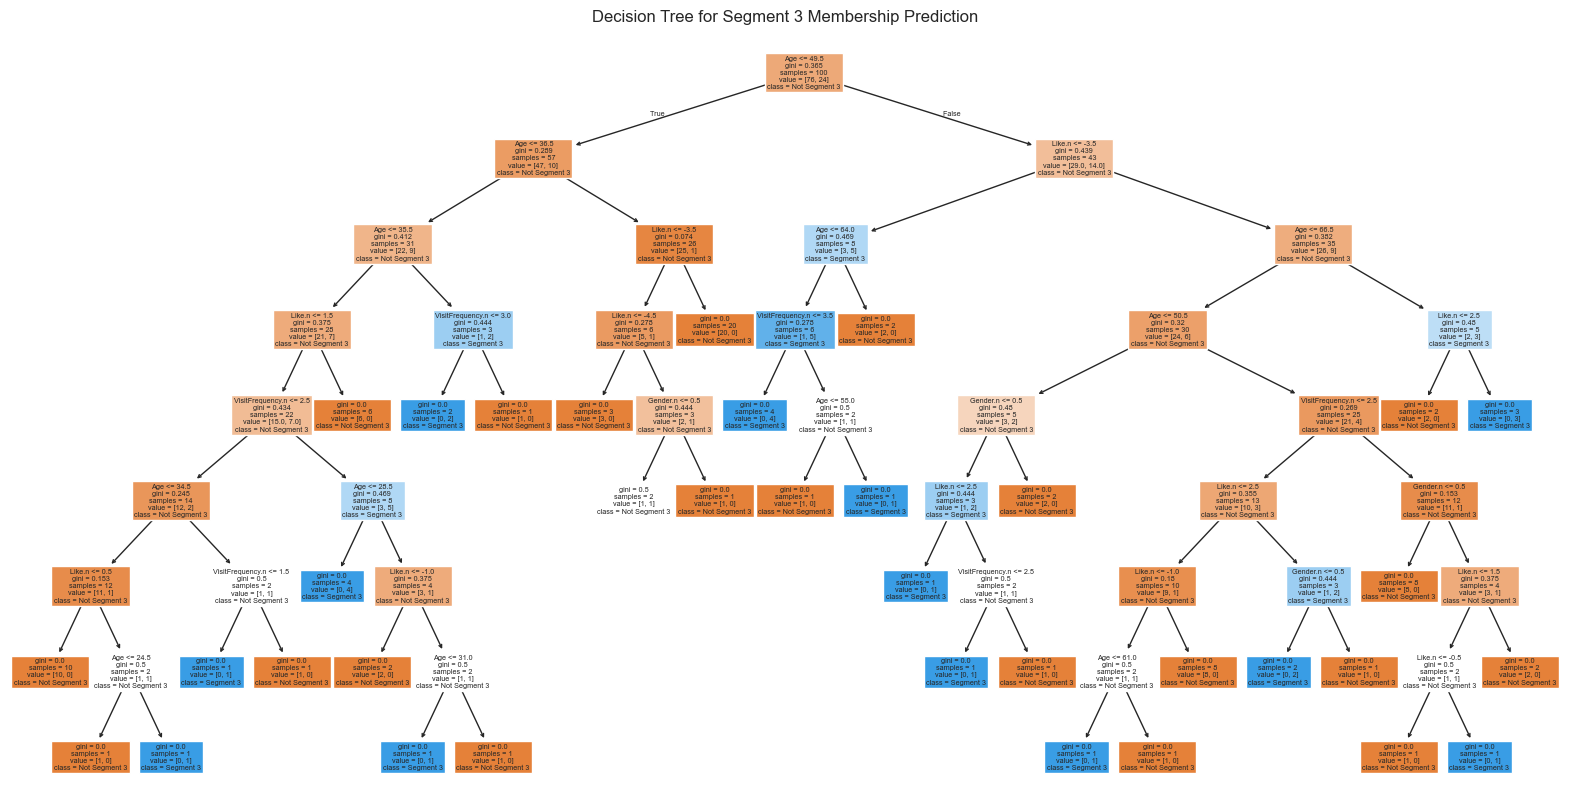

In [82]:
np.random.seed(42)
segments = np.random.choice([1, 2, 3, 4], size=100)  # Simulated segment membership
like_hate = np.random.choice(['I hate it!', '-5', '-4', '-3', '-2', '-1', '0', '+1', '+2', '+3', '+4', 'I love it! +5'], size=100)  # Simulated like/hate variable
gender = np.random.choice(['Male', 'Female'], size=100)  # Simulated gender variable
age = np.random.randint(18, 70, size=100)  # Simulated age variable
visit_frequency = np.random.choice(['Once a week', 'Once a month', 'More than once a month', 'Less than once a month'], size=100)

# Convert categorical variables to numerical codes
like_hate_map = {'I hate it!': -5, '-5': -5, '-4': -4, '-3': -3, '-2': -2, '-1': -1, '0': 0, '+1': 1, '+2': 2, '+3': 3, '+4': 4, 'I love it! +5': 5}
visit_frequency_map = {'Once a week': 1, 'More than once a month': 2, 'Once a month': 3, 'Less than once a month': 4}
gender_map = {'Male': 0, 'Female': 1}

# Apply mappings
df = pd.DataFrame({
    'Segment': segments,
    'Like': like_hate,
    'Gender': gender,
    'Age': age,
    'VisitFrequency': visit_frequency
})
df['Like.n'] = df['Like'].map(like_hate_map)
df['VisitFrequency.n'] = df['VisitFrequency'].map(visit_frequency_map)
df['Gender.n'] = df['Gender'].map(gender_map)
df['Segment3'] = (df['Segment'] == 3).astype(int)
X = df[['Like.n', 'Age', 'VisitFrequency.n', 'Gender.n']]
y = df['Segment3']

# Fit the decision tree classifier
tree = DecisionTreeClassifier()
tree.fit(X, y)

plt.figure(figsize=(20, 10))
plot_tree(tree, feature_names=['Like.n', 'Age', 'VisitFrequency.n', 'Gender.n'], class_names=['Not Segment 3', 'Segment 3'], filled=True)
plt.title('Decision Tree for Segment 3 Membership Prediction')
plt.show()